In [1]:
import numpy as np
from keras import layers
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,Dropout
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from resnets_utils  import *
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

### The ResNet Actual Architecture :
#### (implemented on deeplearning.ai's course)

In [24]:

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    # The Add() function adds two layers inputs together. if we want to add two layers we should use this func.
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [25]:

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), padding='same' ,name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1) ,name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    ## here out shortcut is a Convolution layer, to fit our dimensions with the next layer's input
    # We should use the X_shortcut here, since X_shortcut is the input from the begginning, not X!
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding='valid' ,name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [123]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=[2,2],name= 'avg_pool')(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dropout(0.2)(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model


In [321]:
modelR = ResNet50(input_shape = (64, 64, 3), classes = 6)

## Creating and Augmenting the data:

In [5]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig
X_test = X_test_orig/255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [7]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.1,
      height_shift_range=0.1,
      channel_shift_range=20,
      shear_range=0.2,
      zoom_range=0.25,
      horizontal_flip=True,
      fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_datagen.fit(X_train)
train_gen= train_datagen.flow(x=X_train,y=Y_train,batch_size=30)


### Since the ResNet50 model requires a lot of computation, i will load a model (with the same architecture) that ran ~ 20 epochs:

In [23]:
model = load_model('SIGNS dataset/ResNet50.h5')

### I will apply Transfer Learning, as i freeze the feature layers, extract their outputs and create my own FC layer (fully connected)

In [24]:
for layer in model.layers:
    layer.trainable=False

In [88]:
last_layer= model.get_layer('avg_pool')
last_output=last_layer.output
X = Flatten()(last_output)
X = Dropout(0.2)(X)
X= Dense(6,activation='softmax')(X)
model= Model(model.input,X)

In [26]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.evaluate(X_test,Y_test)

4/4 [==============================] - 0s 104ms/step - loss: 2.0990 - accuracy: 0.1750


[2.0990407466888428, 0.17499999701976776]

In [10]:
#Add EarlyStop , so that the model wont get overfit and get maximum val_accuracy from the training period.
from tensorflow.keras.callbacks import EarlyStopping
earlyStop=EarlyStopping(monitor='val_accuracy', mode='max',verbose=1,patience=4,restore_best_weights=True)                          

In [70]:
history= model.fit(train_gen, epochs = 10 ,steps_per_epoch=len(X_train)/train_gen.batch_size, validation_data=(X_test,Y_test),callbacks=[earlyStop])

Epoch 1/10
36/36 [==============================] - 6s 171ms/step - loss: 1.0701 - accuracy: 0.5972 - val_loss: 0.4338 - val_accuracy: 0.8917
Epoch 2/10
36/36 [==============================] - 6s 167ms/step - loss: 1.0097 - accuracy: 0.6167 - val_loss: 0.3462 - val_accuracy: 0.9250
Epoch 3/10
36/36 [==============================] - 6s 171ms/step - loss: 1.0368 - accuracy: 0.6213 - val_loss: 0.4100 - val_accuracy: 0.8583
Epoch 4/10
36/36 [==============================] - 6s 170ms/step - loss: 1.0626 - accuracy: 0.6000 - val_loss: 0.3999 - val_accuracy: 0.9083
Epoch 5/10
36/36 [==============================] - 6s 164ms/step - loss: 1.0512 - accuracy: 0.6000 - val_loss: 0.3744 - val_accuracy: 0.8917
Epoch 6/10
36/36 [==============================] - 6s 165ms/step - loss: 1.0197 - accuracy: 0.6185 - val_loss: 0.4306 - val_accuracy: 0.8417
Epoch 00006: early stopping


### 0.925 Accuracy rate, after the model ran for another ~20 epochs with the new layers added.
### saving the model:

In [85]:
model.save('ResNet92PercentVer2_1.h5')

### Evaluating the Model's accuracy and loss rate, against another model i have trained:

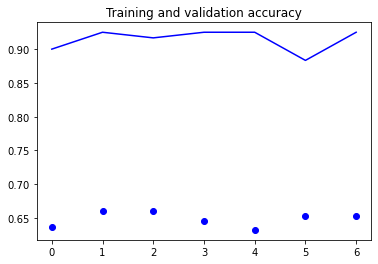

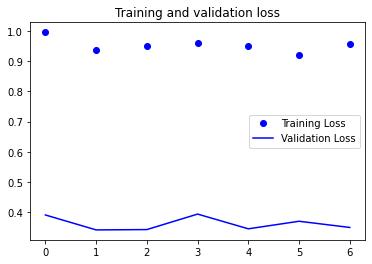

In [35]:
#Around the last 6 epochs
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [175]:
history2 = model.fit(train_gen, epochs = 20 ,steps_per_epoch=len(X_train)/train_gen.batch_size, validation_data=(X_test,Y_test),callbacks=[learning_rate_reduction])

Epoch 1/20
36/36 [==============================] - 8s 218ms/step - loss: 1.9395 - accuracy: 0.3380 - val_loss: 0.8008 - val_accuracy: 0.7583 - lr: 0.0010
Epoch 2/20
36/36 [==============================] - 8s 213ms/step - loss: 1.3420 - accuracy: 0.4500 - val_loss: 0.6810 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 3/20
36/36 [==============================] - 7s 207ms/step - loss: 1.3113 - accuracy: 0.4704 - val_loss: 0.7241 - val_accuracy: 0.7417 - lr: 0.0010
Epoch 4/20
36/36 [==============================] - 7s 208ms/step - loss: 1.2866 - accuracy: 0.4907 - val_loss: 0.6238 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 5/20
36/36 [==============================] - 7s 207ms/step - loss: 1.3019 - accuracy: 0.4694 - val_loss: 0.7061 - val_accuracy: 0.8250 - lr: 0.0010
Epoch 6/20
36/36 [==============================] - ETA: 0s - loss: 1.2931 - accuracy: 0.4806
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
36/36 [==============================] - 7s 206ms/s

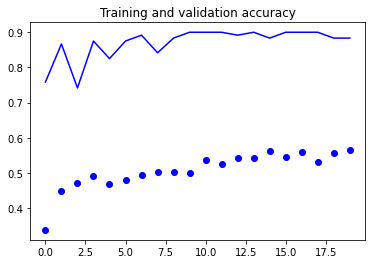

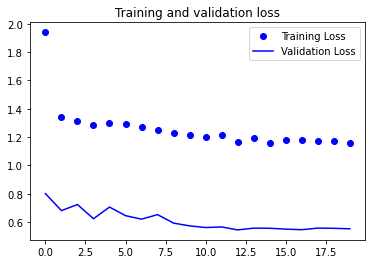

In [178]:
#The whole 20 epochs period
import matplotlib.pyplot as plt
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Testing my own picture:

Input image shape: (1, 64, 64, 3)
class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = 
[[0.00250503 0.06901366 0.62481594 0.06550969 0.18424813 0.05390751]]
Highest value: 0.62481594 , Classified as:  2


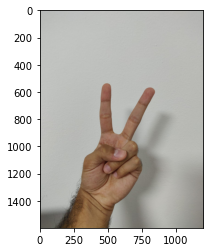

In [114]:
from matplotlib.pyplot import imread
img_path = 'SIGNS dataset/my_images/22.jpeg'
img = image.load_img(img_path, target_size=(64, 64),color_mode='rgb')
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
print('Input image shape:', x.shape)
my_image = imread(img_path)
imshow(my_image)
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
prediction= model.predict(x)
print(prediction)
print("Highest value:", scipy.amax(prediction),", Classified as: ", scipy.argmax(prediction))

In [9]:
modell = load_model('ResNet92PercentVer2_1.h5')

Input image shape: (1, 64, 64, 3)
class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = 
[[0.00953383 0.01795299 0.03509105 0.02963595 0.90360576 0.0041804 ]]
Highest value: 0.90360576 , Classified as:  4


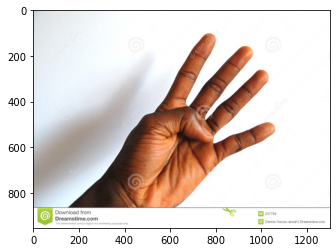

In [4]:
from matplotlib.pyplot import imread
img_path = 'SIGNS dataset/my_images/4bl.jpg'
img = image.load_img(img_path, target_size=(64, 64),color_mode='rgb')
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
print('Input image shape:', x.shape)
my_image = imread(img_path)
imshow(my_image)
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
prediction= modell.predict(x)
print(prediction)
print("Highest value:", scipy.amax(prediction),", Classified as: ", scipy.argmax(prediction))

### A detailed report of the models evaluation :

In [25]:
from sklearn.metrics import classification_report
y_pred= modell.predict(X_test)
y_rounded=np.argmax(Y_test, axis=1)
class_report = classification_report(y_rounded,np.argmax(y_pred,axis=1))


In [23]:
print(class_report)

precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.90      0.95      0.93        20
           2       0.90      0.90      0.90        20
           3       0.94      0.85      0.89        20
           4       0.89      0.85      0.87        20
           5       0.91      1.00      0.95        20

    accuracy                           0.93       120
   macro avg       0.93      0.92      0.92       120
weighted avg       0.93      0.93      0.92       120

